<a href="https://colab.research.google.com/github/liuxx479/Outlier/blob/master/S8_Fit_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import Model
import numpy as np
import os
import tensorflow_datasets as tfds

Populating the interactive namespace from numpy and matplotlib


In [2]:


!pip install --quiet git+https://github.com/liuxx479/Outlier.git
from outlier.datasets import gaussian_convergence



In [3]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
data_path = os.path.join(root,'tensorflow_datasets/')
model_path= os.path.join(root,'models/Keras')

if not os.path.isdir(model_path):
    os.makedirs(model_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dataset, info = tfds.load(name="gaussian_convergence", split="train", data_dir=data_path,with_info=True)

In [0]:
DATASET_SIZE = info.splits['train'].num_examples

In [0]:
def get_S8(params):
    om  = tf.gather(params,0)
    si8 = tf.gather(params,1)
    S8  = si8*tf.sqrt(om/0.3)
    return S8

## Implementing a simple resnet model
def redefine(data):
    x    = data['map'] 
    x    = tf.expand_dims(x,-1)
    y    = data['params']
    y    = get_S8(y)
    return x, y

def downsample(x,y):
    x    = tf.image.resize(x,[128,128])
    return x, y
  
def augmentation(x, y):
  x = tf.image.random_flip_left_right(x)
  x = tf.image.random_flip_up_down(x)
  x = x + 0.02*tf.random.normal(shape=(128,128,1))
  return x, y

In [0]:
DATASET_SIZE = 20000
BATCH_SIZE = 8

train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

full_dataset = dataset.map(redefine).map(downsample)

train_dataset= full_dataset.take(train_size).repeat().map(augmentation).shuffle(buffer_size=2000).batch(BATCH_SIZE)
test_dataset = full_dataset.skip(train_size).take(test_size).batch(BATCH_SIZE)

In [0]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path 
    X = Conv2D(F2, (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu') (X)

    # Third component of main path 
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer=glorot_uniform(seed =0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer=glorot_uniform(seed =0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [0]:
def ResNet50(input_shape = (128, 128, 1), params = 1):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    # X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    # X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    # X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    # X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    # X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    # X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    # X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    # X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    # X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    # X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    # X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    # X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL . Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D()(X)

    # output layer
    X = Flatten()(X)
    X = Dense(params, name='fc' + str(params), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [18]:
res_net_model = ResNet50()
res_net_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
checkpoint_file = os.path.join(model_path+'/weights.{epoch:02d}-{val_loss:.2f}.hdf5')
ckpt_callback   = keras.callbacks.ModelCheckpoint(filepath=checkpoint_file, monitor='val_loss')
hists = []

In [0]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    try:
        return max(paths, key=os.path.getctime)
    except:
        return None

In [21]:
latest_file=newest(model_path)
print(latest_file)

None


In [22]:
callbacks     = [ckpt_callback]
if latest_file is None:
    res_net_model.compile(optimizer=keras.optimizers.Adam(),loss='mse',metrics=['mse'])   
else:
    res_net_model = keras.models.load_model(latest_file)
history = res_net_model.fit(train_dataset, epochs=3, batch_size=BATCH_SIZE,
                    validation_data=test_dataset, verbose=1, 
                    steps_per_epoch=int(0.8*20000/BATCH_SIZE)-1,
                    validation_steps=2)

Epoch 1/3
1999/1999 [==============================] - 207s 104ms/step - loss: 0.5923 - mse: 0.5923 - val_loss: 0.0910 - val_mse: 0.0910
Epoch 2/3
1999/1999 [==============================] - 169s 84ms/step - loss: 0.0842 - mse: 0.0842 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 3/3
1999/1999 [==============================] - 188s 94ms/step - loss: 0.0534 - mse: 0.0534 - val_loss: 0.0585 - val_mse: 0.0585


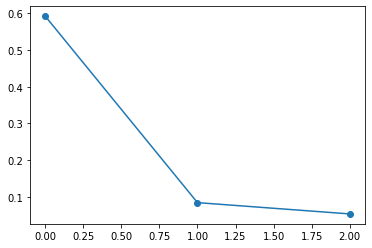

In [23]:
plt.plot(history.history['loss'], marker='o')

In [0]:
truth = list(test_dataset.as_numpy_iterator()) 


In [0]:
truth[0][0].shape

(32, 128, 128, 1)

In [0]:


predictions = res_net_model.predict(x=truth[0][0])



In [30]:
print(predictions.shape)
print(truth[1][1].shape)

(8, 1)
(8,)


In [31]:
print(truth[1][1])
print(predictions)


[1.0081496  0.5585804  0.6934614  0.9299813  0.8084125  0.5019638
 0.8331738  0.30797407]
[[0.61770606]
 [0.5937376 ]
 [0.6619957 ]
 [0.6215235 ]
 [0.6061509 ]
 [0.6184734 ]
 [0.66192716]
 [0.60767615]]


In [32]:
np.mean((predictions-truth[1][1])**2)

0.055967823

(0.30797407031059265, 1.0081496238708496)

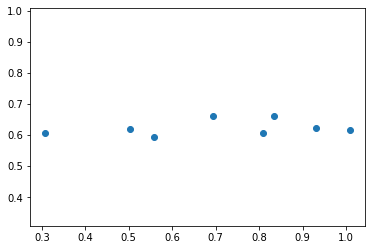

In [33]:
plt.plot(truth[1][1],predictions, marker='o', ls='')
plt.ylim(min(truth[1][1]),max(truth[1][1]))

In [0]:
plt.